In [1]:
import matplotlib.pyplot as plt
import numpy as np
import helper

import torch.nn as nn
import torchvision.models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import torchvision.utils
import torch
import pandas as pd
from torchinfo import summary
from PIL import Image
from torchvision.transforms import ToTensor
from glob import glob
from torch.utils.data import Dataset, DataLoader, random_split
from copy import copy
from collections import defaultdict
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
from sklearn.metrics import classification_report
from tqdm import tqdm
import math
from torcheval.metrics import BinaryAccuracy
import os
from torch.nn.modules.batchnorm import _BatchNorm
import torchmetrics
import timm
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
batch_size=1
image_count=50
img_size=512
tf = ToTensor()


In [2]:

class CustomDataset(Dataset):
    def __init__(self, image_list, label_list):
        self.img_path = image_list

        self.label = label_list


    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        image_tensor = torch.empty((image_count,3, img_size, img_size))
        
        image_file_list = glob(self.img_path[idx]+'/*.jpg')
        image_index = torch.randint(low=0, high=len(
            image_file_list)-1, size=(image_count,))
        count = 0
        for index in image_index:
            image = 1-tf(Image.open(image_file_list[index]))
            image_tensor[count] = image
            count += 1
        label_tensor =  self.label[idx]
        return image_tensor, label_tensor
    
train_image_transition_path='../../data/dataset/gcu/MMRd/train/Defect/*'
train_image_not_transition_path='../../data/dataset/gcu/MMRd/train/Normal/*'
test_image_transition_path='../../data/dataset/gcu/MMRd/test/Defect/*'
test_image_not_transition_path='../../data/dataset/gcu/MMRd/test/Normal/*'

train_image_list = []
train_label_list = []
image_abnormal_list = glob(train_image_transition_path)
image_abnormal_label = torch.ones(len(image_abnormal_list), 1)
image_normal_list = glob(train_image_not_transition_path)
image_normal_label = torch.zeros(len(image_normal_list), 1)
train_image_list.extend(image_abnormal_list)
train_image_list.extend(image_abnormal_list)
train_image_list.extend(image_abnormal_list)
train_image_list.extend(image_normal_list)
train_label_list.extend(image_abnormal_label)
train_label_list.extend(image_abnormal_label)
train_label_list.extend(image_abnormal_label)
train_label_list.extend(image_normal_label)

test_image_list = []
test_label_list = []
image_abnormal_list = glob(test_image_transition_path)
image_abnormal_label = torch.ones(len(image_abnormal_list), 1)
image_normal_list = glob(test_image_not_transition_path)
image_normal_label = torch.zeros(len(image_normal_list), 1)
test_image_list.extend(image_abnormal_list)
test_image_list.extend(image_abnormal_list)
test_image_list.extend(image_abnormal_list)
test_image_list.extend(image_normal_list)
test_label_list.extend(image_abnormal_label)
test_label_list.extend(image_abnormal_label)
test_label_list.extend(image_abnormal_label)
test_label_list.extend(image_normal_label)
train_image_list.extend(test_image_list)
train_label_list.extend(test_label_list)
train_dataset = CustomDataset(train_image_list, F.one_hot(torch.tensor(train_label_list).to(torch.int64)))

test_dataset = CustomDataset(test_image_list, F.one_hot(torch.tensor(test_label_list).to(torch.int64)))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
validation_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [3]:
class FeatureExtractor(nn.Module):
    """Feature extoractor block"""
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        cnn1= timm.create_model('efficientnet_b2', pretrained=True)
        self.feature_ex = nn.Sequential(*list(cnn1.children())[:-1])

    def forward(self, inputs):
        features = self.feature_ex(inputs)
        
        return features
    
class AttentionMILModel(nn.Module):
    def __init__(self, num_classes, image_feature_dim,feature_extractor_scale1: FeatureExtractor):
        super(AttentionMILModel, self).__init__()
        self.num_classes = num_classes
        self.image_feature_dim = image_feature_dim

        # Remove the classification head of the CNN model
        self.feature_extractor = feature_extractor_scale1
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(image_feature_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )
        
        # Classification layer
        self.classification_layer = nn.Linear(image_feature_dim, num_classes)

    def forward(self, inputs):
        batch_size, num_tiles, channels, height, width = inputs.size()
        
        # Flatten the inputs
        inputs = inputs.view(-1, channels, height, width)
        
        # Feature extraction using the pre-trained CNN
        features = self.feature_extractor(inputs)  # Shape: (batch_size * num_tiles, 2048, 1, 1)
        
        # Reshape features
        features = features.view(batch_size, num_tiles, -1)  # Shape: (batch_size, num_tiles, 2048)
        
        # Attention mechanism
        attention_weights = self.attention(features)  # Shape: (batch_size, num_tiles, 1)
        attention_weights = F.softmax(attention_weights, dim=1)  # Normalize attention weights
        
        # Apply attention weights to features
        attended_features = torch.sum(features * attention_weights, dim=1)  # Shape: (batch_size, 2048)
        
        # Classification layer
        logits = self.classification_layer(attended_features)  # Shape: (batch_size, num_classes)
        
        return logits  
    
class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, adaptive=False, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups
        self.defaults.update(self.base_optimizer.defaults)

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                self.state[p]["old_p"] = p.data.clone()
                e_w = (torch.pow(p, 2) if group["adaptive"] else 1.0) * p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.data = self.state[p]["old_p"]  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
                    torch.stack([
                        ((torch.abs(p) if group["adaptive"] else 1.0) * p.grad).norm(p=2).to(shared_device)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm

    def load_state_dict(self, state_dict):
        super().load_state_dict(state_dict)
        self.base_optimizer.param_groups = self.param_groups
        
def disable_running_stats(model):
    def _disable(module):
        if isinstance(module, _BatchNorm):
            module.backup_momentum = module.momentum
            module.momentum = 0

    model.apply(_disable)

def enable_running_stats(model):
    def _enable(module):
        if isinstance(module, _BatchNorm) and hasattr(module, "backup_momentum"):
            module.momentum = module.backup_momentum
            
import transformers

Feature_Extractor=FeatureExtractor()
model = AttentionMILModel(2,1408,Feature_Extractor)
model = model.to(device)
base_optimizer = torch.optim.SGD
optimizer = SAM(model.parameters(), base_optimizer, lr=2e-3, momentum=0.9)
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=2).to(device)
summary(model,(batch_size,image_count,3,img_size,img_size))

Layer (type:depth-idx)                                  Output Shape              Param #
AttentionMILModel                                       [1, 2]                    --
├─FeatureExtractor: 1-1                                 [50, 1408]                --
│    └─Sequential: 2-1                                  [50, 1408]                --
│    │    └─Conv2d: 3-1                                 [50, 32, 256, 256]        864
│    │    └─BatchNormAct2d: 3-2                         [50, 32, 256, 256]        64
│    │    └─Sequential: 3-3                             [50, 352, 16, 16]         7,201,634
│    │    └─Conv2d: 3-4                                 [50, 1408, 16, 16]        495,616
│    │    └─BatchNormAct2d: 3-5                         [50, 1408, 16, 16]        2,816
│    │    └─SelectAdaptivePool2d: 3-6                   [50, 1408]                --
├─Sequential: 1-2                                       [1, 50, 1]                --
│    └─Linear: 2-2                          

  0%|          | 0/1292 [00:00<?, ?it/s]

epoch: 1/1000 Step: 1293 loss : 0.3482 accuracy: 0.4930: 100%|██████████| 1292/1292 [28:44<00:00,  1.33s/it]
Validation epoch: 1/1000 Step: 134 loss : 0.3445  accuracy: 0.4436: 100%|██████████| 133/133 [01:20<00:00,  1.65it/s]
epoch: 2/1000 Step: 1293 loss : 0.3428 accuracy: 0.4791: 100%|██████████| 1292/1292 [29:26<00:00,  1.37s/it]
Validation epoch: 2/1000 Step: 134 loss : 0.3447  accuracy: 0.4737: 100%|██████████| 133/133 [01:24<00:00,  1.58it/s]
epoch: 3/1000 Step: 1293 loss : 0.3423 accuracy: 0.5279: 100%|██████████| 1292/1292 [29:48<00:00,  1.38s/it]
Validation epoch: 3/1000 Step: 134 loss : 0.3445  accuracy: 0.4436: 100%|██████████| 133/133 [01:18<00:00,  1.70it/s]
epoch: 4/1000 Step: 1293 loss : 0.3419 accuracy: 0.5108: 100%|██████████| 1292/1292 [31:43<00:00,  1.47s/it]
Validation epoch: 4/1000 Step: 134 loss : 0.3441  accuracy: 0.4737: 100%|██████████| 133/133 [01:34<00:00,  1.41it/s]
epoch: 5/1000 Step: 1293 loss : 0.3417 accuracy: 0.5364: 100%|██████████| 1292/1292 [30:08<0

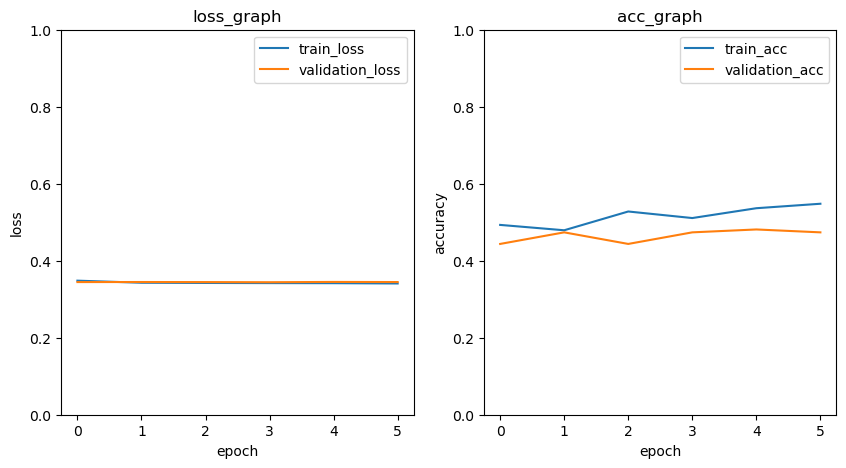

epoch: 7/1000 Step: 1293 loss : 0.3397 accuracy: 0.5728: 100%|██████████| 1292/1292 [29:25<00:00,  1.37s/it]
Validation epoch: 7/1000 Step: 134 loss : 0.3449  accuracy: 0.4436: 100%|██████████| 133/133 [01:16<00:00,  1.75it/s]
epoch: 8/1000 Step: 1293 loss : 0.3381 accuracy: 0.5921: 100%|██████████| 1292/1292 [29:26<00:00,  1.37s/it]
Validation epoch: 8/1000 Step: 134 loss : 0.3480  accuracy: 0.5038: 100%|██████████| 133/133 [01:28<00:00,  1.50it/s]
epoch: 9/1000 Step: 1293 loss : 0.3307 accuracy: 0.6579: 100%|██████████| 1292/1292 [29:27<00:00,  1.37s/it]
Validation epoch: 9/1000 Step: 134 loss : 0.3450  accuracy: 0.5263: 100%|██████████| 133/133 [01:24<00:00,  1.58it/s]
epoch: 10/1000 Step: 1293 loss : 0.3137 accuracy: 0.7020: 100%|██████████| 1292/1292 [29:53<00:00,  1.39s/it]
Validation epoch: 10/1000 Step: 134 loss : 0.3416  accuracy: 0.5188: 100%|██████████| 133/133 [01:23<00:00,  1.59it/s]
epoch: 11/1000 Step: 1293 loss : 0.2860 accuracy: 0.7322: 100%|██████████| 1292/1292 [29:0

KeyboardInterrupt: 

In [4]:
MIN_loss=5000
train_loss_list=[]
val_loss_list=[]
train_acc_list=[]
sig=nn.Sigmoid()
val_acc_list=[]
numSample_list = [len(torch.where(torch.tensor(train_label_list)==0.)[0]), len(torch.where(torch.tensor(train_label_list)==1.)[0])]
weights = (torch.tensor([1 - (x / sum(numSample_list)) for x in numSample_list])).to(device)

for epoch in range(1000):
    train=tqdm(train_dataloader)
    count=0
    running_loss = 0.0
    acc_loss=0
    model.train()
    for x, y in train:
        
        y = y.to(device).float()
        count+=1
        x=x.to(device).float()
        enable_running_stats(model)
        optimizer.zero_grad()  # optimizer zero 로 초기화
        predict = model(x).to(device)
        cost = F.cross_entropy(predict.softmax(dim=1), y,weights) # cost 구함
        acc=accuracy(predict.softmax(dim=1).argmax(dim=1),y.argmax(dim=1))
        cost.backward() # cost에 대한 backward 구함
        optimizer.first_step(zero_grad=False)
        disable_running_stats(model)
        predict = model(x).to(device)
        cost1 = F.cross_entropy(predict.softmax(dim=1), y,weights) # cost 구함
        cost1.backward() # cost에 대한 backward 구함
        optimizer.second_step(zero_grad=True)
        running_loss += cost.item()
        acc_loss+=acc
        train.set_description(f"epoch: {epoch+1}/{1000} Step: {count+1} loss : {running_loss/count:.4f} accuracy: {acc_loss/count:.4f}")
    train_loss_list.append((running_loss/count))
    train_acc_list.append((acc_loss/count).cpu().detach().numpy())
#validation
    val=tqdm(validation_dataloader)
    model.eval()
    count=0
    val_running_loss=0.0
    acc_loss=0
    with torch.no_grad():
        for x, y in val:
            y = y.to(device).float()
            count+=1
            x=x.to(device).float()
            predict = model(x).to(device)
            cost = F.cross_entropy(predict.softmax(dim=1), y,weights) # cost 구함
            acc=accuracy(predict.softmax(dim=1).argmax(dim=1),y.argmax(dim=1))
            val_running_loss+=cost.item()
            acc_loss+=acc
            val.set_description(f"Validation epoch: {epoch+1}/{1000} Step: {count+1} loss : {val_running_loss/count:.4f}  accuracy: {acc_loss/count:.4f}")
        val_loss_list.append((val_running_loss/count))
        val_acc_list.append((acc_loss/count).cpu().detach().numpy())
    if epoch%100==5:
        plt.figure(figsize=(10,5))
        plt.subplot(1, 2, 1) 
        plt.title('loss_graph')
        plt.plot(np.arange(epoch+1),train_loss_list,label='train_loss')
        plt.plot(np.arange(epoch+1),val_loss_list,label='validation_loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.ylim([0, 1]) 
        plt.legend()
        plt.subplot(1, 2, 2)  
        plt.title('acc_graph')
        plt.plot(np.arange(epoch+1),train_acc_list,label='train_acc')
        plt.plot(np.arange(epoch+1),val_acc_list,label='validation_acc')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.ylim([0, 1]) 
        plt.legend()
        plt.show()
        
        
    if MIN_loss>(val_running_loss/count):
        torch.save(model.state_dict(), '../../model/mmrd(MIL)/attention_MIL_callback.pt')
        MIN_loss=(val_running_loss/count)
torch.save(model.state_dict(), '../../model/mmrd(MIL)/attention_MIL.pt')